# Check firing rate of each neuron

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import pickle

from dataloader import BaseDataset
from utils.util import get_place_cell
from utils.plot_utils import label_diff
from param import *

mi_dir = ParamDir().output_dir

## with all the cells

In [2]:

spikes_all = []
mouse_type_list = []
ratio_all = []
for data_dir in ParamDir().data_list:

    data_name = str(data_dir).split('/')[-1]
    mouse_type = "KO" if "KO" in data_name else "WT"
    dataset = BaseDataset(data_dir, False, ParamData().shuffle, ParamData().random_state)
    position = dataset._discretize_coords()

    # mean firing rate at each position
    n_time, n_neuron = dataset.spikes.shape
    spikes_all.extend(list((dataset.spikes.sum(axis=0))/(n_time/3)))
    mouse_type_list.extend([f"{mouse_type}"]*len(dataset.spikes.sum(axis=0)))



In [3]:
df_firing_rate_all = pd.DataFrame(spikes_all, columns=["firing rate"])
df_firing_rate_all["mouse type"] = mouse_type_list
means = df_firing_rate_all.groupby("mouse type").mean().values
errors = df_firing_rate_all.groupby("mouse type").max().values -.02
ind = [str(i+1) for i in range(len(means))]

plot_data = [
    df_firing_rate_all[df_firing_rate_all["mouse type"]=="KO"]["firing rate"], 
    df_firing_rate_all[df_firing_rate_all["mouse type"]=="WT"]["firing rate"]
    ]

In [4]:
stats.ttest_ind(plot_data[0], plot_data[1])

Ttest_indResult(statistic=4.956920667974125, pvalue=8.782940828382137e-07)

Text(0.5, 1.0, 'firing rate of each neuron')

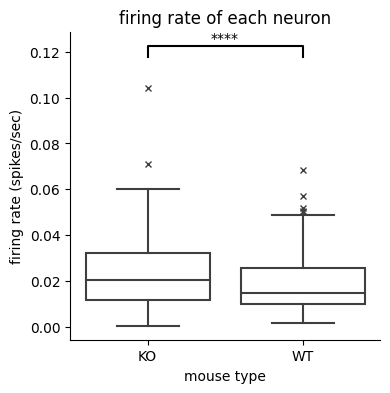

In [5]:
fig, ax = plt.subplots(figsize=(4,4))
sns.despine()

sns.boxplot([df_firing_rate_all[df_firing_rate_all["mouse type"]=="KO"]["firing rate"], df_firing_rate_all[df_firing_rate_all["mouse type"]=="WT"]["firing rate"]],
            ax=ax,
            boxprops={"facecolor": (0, 0, 0, 0)},
            flierprops={"marker": "x"})
label_diff(0, 1, "****", ind=[0,1], Y=means, errors=errors, ax=ax, barh=.005)

ax.set_xticklabels(["KO", "WT"])
ax.set_xlabel("mouse type")
ax.set_ylabel("firing rate (spikes/sec)")
ax.set_title("firing rate of each neuron")



## with place cells

In [7]:

spikes_all = []
mouse_type_list = []
cell_type_list = []
data_name_list = []
for data_dir in ParamDir().data_list:

    data_name = str(data_dir).split('/')[-1]
    mouse_type = "KO" if "KO" in data_name else "WT"
    dataset = BaseDataset(data_dir, False, ParamData().shuffle, ParamData().random_state)
    position = dataset._discretize_coords()

    with open(mi_dir/data_name/"MI_all.pickle","rb") as f:
        results_all = pickle.load(f)
    pc_beh_id, pc_event_id = get_place_cell(results_all, 0.01)

    # mean firing rate at each position
    n_time, n_neuron = dataset.spikes.shape
    spikes_all.extend(list((dataset.spikes.sum(axis=0))/(n_time/3)))
    mouse_type_list.extend([f"{mouse_type}"]*n_neuron)
    cell_type_list.extend(["pc" if i in pc_beh_id else "np" for i in range(n_neuron)]) # pc: place cell; np: non place cell
    data_name_list.extend([f"{data_name}"]*n_neuron)

df_firing_rate_all = pd.DataFrame(spikes_all, columns=["firing rate"])
df_firing_rate_all["mouse type"] = mouse_type_list
df_firing_rate_all["cell type"] = cell_type_list
df_firing_rate_all["data name"] = data_name_list

In [8]:
# WT:pc and KO:pc
stats.ttest_ind(df_firing_rate_all[(df_firing_rate_all["mouse type"]=="WT")&(df_firing_rate_all["cell type"]=="pc")]["firing rate"],
                df_firing_rate_all[(df_firing_rate_all["mouse type"]=="KO")&(df_firing_rate_all["cell type"]=="pc")]["firing rate"])


Ttest_indResult(statistic=-4.072932904580858, pvalue=6.73551749453269e-05)

In [9]:
# WT:pc and np
stats.ttest_ind(df_firing_rate_all[(df_firing_rate_all["mouse type"]=="WT")&(df_firing_rate_all["cell type"]=="pc")]["firing rate"],
                df_firing_rate_all[(df_firing_rate_all["mouse type"]=="WT")&(df_firing_rate_all["cell type"]=="np")]["firing rate"])


Ttest_indResult(statistic=6.885815391652819, pvalue=1.7341692241911267e-11)

In [10]:
# KO:pc and np
stats.ttest_ind(df_firing_rate_all[(df_firing_rate_all["mouse type"]=="KO")&(df_firing_rate_all["cell type"]=="pc")]["firing rate"],
                df_firing_rate_all[(df_firing_rate_all["mouse type"]=="KO")&(df_firing_rate_all["cell type"]=="np")]["firing rate"])


Ttest_indResult(statistic=4.907788570719105, pvalue=1.5603510456374705e-06)

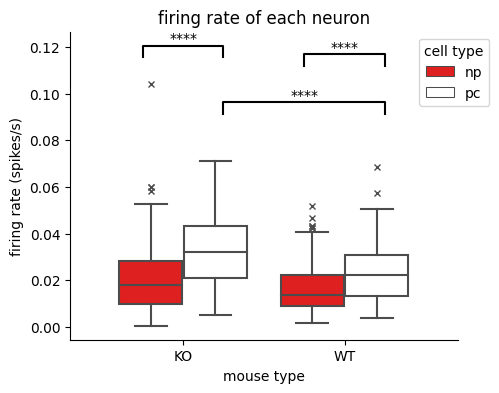

In [16]:
fig, ax = plt.subplots(figsize=(5,4))
sns.despine()

sns.boxplot(x="mouse type", y="firing rate", hue="cell type", data=df_firing_rate_all, 
            ax=ax,
            #boxprops={"facecolor": (0, 0, 0, 0)},
            palette={"np": "red", "pc": "white"},
            flierprops={"marker": "x"})

ind = [-.25, .25, .75 , 1.25]

# KO:pc and WT:pc
label_diff(1, 3, "****", 
           ind=ind, 
           Y=df_firing_rate_all.groupby(["mouse type", "cell type"])[["firing rate"]].mean().values, 
           errors=df_firing_rate_all.groupby(["mouse type", "cell type"])[["firing rate"]].max().values-.02, 
           ax=ax, barh=.005)
# KO:pc and np
label_diff(0, 1, "****", 
           ind=ind, 
           Y=df_firing_rate_all.groupby(["mouse type", "cell type"])[["firing rate"]].mean().values, 
           errors=df_firing_rate_all.groupby(["mouse type", "cell type"])[["firing rate"]].max().values-.02, 
           ax=ax, barh=.005)
# WT:pc and np
label_diff(2, 3, "****", 
           ind=ind, 
           Y=df_firing_rate_all.groupby(["mouse type", "cell type"])[["firing rate"]].mean().values, 
           errors=df_firing_rate_all.groupby(["mouse type", "cell type"])[["firing rate"]].max().values+.01, 
           ax=ax, barh=.005)

ax.set_title("firing rate of each neuron")
ax.set_ylabel("firing rate (spikes/s)")
ax.legend( bbox_to_anchor=(1.1,1), title="cell type")


### KO mice with place cell

In [24]:
df_firing_rate_all[
    (df_firing_rate_all["mouse type"]=="KO")&
    (df_firing_rate_all["cell type"]=="pc")].groupby("data name")["firing rate"].mean()

data name
090817 OF CaMKII HKO M22-n1    0.030991
091317 OF CaMKII HKO M19-n1    0.039554
091317 OF CaMKII HKO M20-n1    0.038515
092217 OF CaMKII HKO M30-n1    0.022618
CK_KO_RN1_OF                   0.010382
Name: firing rate, dtype: float64